# Computational topology - Sensors

You are given a number of points on the sphere of radius 1. You should view them as sensors on the surface of the Earth.  The sensors are used to gather data and form a sensor network with parameters $r$ and $R$:
- each sensor gathers data from the surrounding area in the shape of a circle of radius $R$,
- each sensor can communicate with other sensors which are at most $r$ away.

Project goal:  Determine $r$ and $R$, so that
1. numbers $r$ and $R$ are as small as possible (that would decrease the cost of sensors),
2. the sensor network is connected (i.e.  the Vietoris-Rips graph is connected),
3. the sensor network covers the whole sphere (the Čech complex should be homotopy equivalent to the sphere, i.e.  the Euler characteristic of the Čech complex should be that of a sphere).

Furthermore, once the parameters $r$ and $R$ are established, the program should return a list of obsolete sensors, i.e.  sensors, whose removal would not change the desired properties 2. and 3. of the sensor network.

**Data**: The input data is a set of points on the sphere of radius 1.

**Results**: The result should be required parameter values $r$ and $R$.
Start with an estimate for $r$ and $R$ and keep optimizing the values. To generate the Čech complex you can use the MiniBall algorithm.

**Data generator**: You should also produce a distribution of 50 points on the sphere with parameters $r$ and $R$ as small as possible.

In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import distance_matrix, SphericalVoronoi, geometric_slerp
from itertools import chain, combinations

In [2]:
with open('sensors.txt') as f:
    points = np.asarray([[float(p) for p in point.split(',')]
                         for point in f.read()[2:-3].split('},{')])
pprint(points)

array([[ 0.0740328 , -0.0669765 , -0.995004  ],
       [-0.0424728 , -0.0903481 , -0.995004  ],
       [ 0.49942   , -0.26344   , -0.825336  ],
       [ 0.520044  ,  0.219943  , -0.825336  ],
       [ 0.158841  ,  0.54184   , -0.825336  ],
       [-0.318986  ,  0.465907  , -0.825336  ],
       [-0.562607  ,  0.0478954 , -0.825336  ],
       [-0.393151  , -0.405282  , -0.825336  ],
       [ 0.0649644 , -0.560893  , -0.825336  ],
       [ 0.475382  , -0.304685  , -0.825336  ],
       [ 0.866629  , -0.207856  , -0.453596  ],
       [ 0.844371  ,  0.28511   , -0.453596  ],
       [ 0.563236  ,  0.690663  , -0.453596  ],
       [ 0.109417  ,  0.884465  , -0.453596  ],
       [-0.377948  ,  0.807097  , -0.453596  ],
       [-0.749438  ,  0.482279  , -0.453596  ],
       [-0.891156  ,  0.00959889, -0.453596  ],
       [-0.759652  , -0.466025  , -0.453596  ],
       [-0.395246  , -0.798769  , -0.453596  ],
       [ 0.0903402 , -0.886617  , -0.453596  ],
       [ 0.548228  , -0.702635  , -0.453

In [3]:
def compute_radii(points):
    # coverage
    sv = SphericalVoronoi(points)
    sv.sort_vertices_of_regions()
    R = max(distance_matrix(np.array([point]),
                            sv.vertices[sv.regions[i]]).max()
            for i, point in enumerate(sv.points))
    # connectivity
    diagram = ripser(points)['dgms'][0]
    r = diagram[diagram[:, 1] < float('inf')].max()
    return R, r

In [4]:
compute_radii(points)

(0.3621207618447775, 0.4965033233165741)

In [5]:
def find_obsolete(points):
    R, r = compute_radii(points)
    obsolete = []
    for i in range(len(points)):
        points_without = np.delete(points, i, axis=0)
        R_without, r_without = compute_radii(points_without)
        if np.allclose([R_without, r_without], [R, r]):
            obsolete.append(i)
    n = len(obsolete)
    if n > 1:
        obsolete_combinations = []
        for comb in chain.from_iterable(combinations(obsolete, i + 1) for i in range(n)):
            points_without = np.delete(points, comb, axis=0)
            R_without, r_without = compute_radii(points_without)
            if np.allclose([R_without, r_without], [R, r]):
                obsolete_combinations.append(comb)
        obsolete += obsolete_combinations
    return obsolete

In [6]:
find_obsolete(points)

[2]

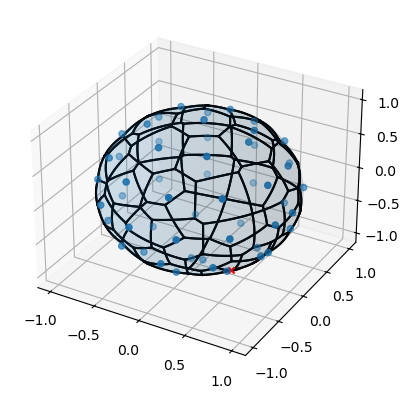

In [7]:
sv = SphericalVoronoi(points)
sv.sort_vertices_of_regions()
obs_arg = find_obsolete(points)
obsolete = points[obs_arg]
necessary = np.delete(points, obs_arg, axis=0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ax.plot_surface(np.outer(np.cos(u), np.sin(v)),
                np.outer(np.sin(u), np.sin(v)),
                np.outer(np.ones(np.size(u)), np.cos(v)),
                alpha=.1)

ax.scatter(necessary[:, 0],
           necessary[:, 1],
           necessary[:, 2])
ax.scatter(obsolete[:, 0],
           obsolete[:, 1],
           obsolete[:, 2],
           c='r', marker='x')

# ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2])

t = np.linspace(0, 1, 10)
for region in sv.regions:
    n = len(region)
    for i in range(n):
        start = sv.vertices[region][i]
        end = sv.vertices[region][(i + 1) % n]
        result = geometric_slerp(start, end, t)
        ax.plot(result[..., 0],
                result[..., 1],
                result[..., 2],
                c='k')
plt.show()

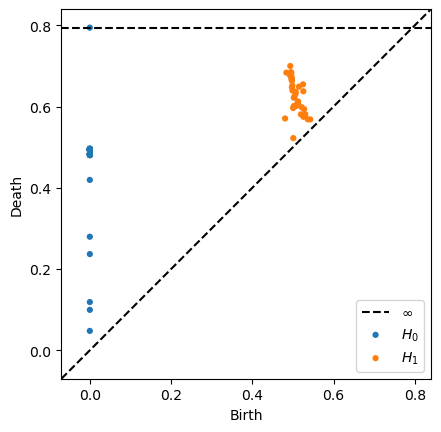

In [8]:
diagrams = ripser(points)['dgms']
plot_diagrams(diagrams)